In [1]:
import numpy as np
import os
import glob
import cv2
from scipy.spatial.distance import cdist
from PIL import Image
import matplotlib.pyplot as plt

# Spectral Clustering

Build similarity graph (very possibly by kernel) mapping to eigenspace of graph Laplacian (imagined as indicators)

![title](note/spectral_clustering_algorithm.PNG)

## Load Image

***info_C means the RGB information of images.(RGB value)***<br>
C : (pixel, (B, G, R))<br>
***info_S means the spatial information of images.(coordinate of pixel)***<br>
S : (pixel, (x, y))<br>

In [2]:
def extract_info(image):
    img_C = image.reshape((10000,3)) 
    img_S = np.array([(i,j) for i in range(100) for j in range(100)])
    return img_S, img_C

## Kernel

By using the reorder data to compute the ***Gram matrix***.

$k(x,x') = e^{-\gamma_{s}||S(x)-S(x')||^{2}} \times e^{-\gamma_{c}||C(x)-C(x')||^{2}}$

In [3]:
def kernel(gamma_S, gamma_C, S, C):
    result_S = np.exp(-gamma_S*cdist(S, S, 'sqeuclidean'))
    result_C = np.exp(-gamma_C*cdist(C, C, 'sqeuclidean'))
    Gram_matrix = np.multiply(result_S, result_C)
    return Gram_matrix

## Initial

Initialize centers $\mu_{k}$ (e.g. randomly pick $k$ data points as centers)<br>

In [4]:
def initial_center(K, U, info_S, mode="random"):
    cluster = np.random.randint(0, K, 10000)
    if mode == 'random':
        high = U.max(axis=0)
        low = U.min(axis=0)
        interval = high - low
        centroids =	np.random.rand(K, K)
        for i in range(K):
            centroids[:, i] *= interval[i]
            centroids[:, i] += low[i]
    elif mode == 'kmeans++':
        centroids = [U[np.random.choice(range(10000)), :]]
        for i in range(K - 1):
            dist = cdist(U, centroids, 'euclidean').min(axis=1)
            prob = dist / np.sum(dist)
            centroids.append(U[np.random.choice(range(10000), p=prob)])
    centroids = np.array(centroids)
    return centroids

## Laplacian

***Ratio cut***<br>
$L = D-W$<br>
***Normalized cut***<br>
$L=I-D^{\frac{-1}{2}}WD^{\frac{-1}{2}}$

In [5]:
def compute_Laplacian(W, cut):
    if cut == 'ratio cut':
        D = np.sum(W)
        L = D - W
    else:
        D = np.sum(W, axis=1)
        D_sqr = np.diag(np.power(D, -0.5))
        L = np.identity(10000) - D_sqr @ W @ D_sqr
    
    return L

## Eigen

np.linalg.eig(a)<br>
***Compute the eigenvalues and right eigenvectors of a square array.***<br>
input a : Matrices for which the eigenvalues and right eigenvectors will be computed.<br>
output v, vector : The eigenvalues, each repeated according to its multiplicity & The normalized (unit “length”) <br>eigenvectors, such that the column v[:,i] is the eigenvector corresponding to the eigenvalue w[i].

In [6]:
def compute_eigen(L, mode, cut, image_name):
    name_value = f"eigen_value_{mode}_{cut}_"+image_name+".npy"
    name_vector = f"eigen_vector_{mode}_{cut}_"+image_name+".npy"
    
    if (os.path.exists(name_value) and os.path.exists(name_vector)):
        print(f'there is npy already in folder, load the npy file')
        eigen_value = np.load(name_value)
        eigen_vector = np.load(name_vector)
    else:
        print(f'there is no npy already in folder, computing eigen problem...')
        eigen_value, eigen_vector = np.linalg.eig(L)
        np.save(name_value , eigen_value)
        np.save(name_vector, eigen_vector)
    return eigen_value, eigen_vector

## U

Let $U\in \mathbb{R}$ be the matrix containing the vectors $u_{1},...,u_{k}$ as collums.

In [7]:
def compute_U(eigen_values, eigen_vectors, K):
    idx = np.argsort(eigen_values)
    eigen_vec = eigen_vectors[:, idx]
    U = eigen_vec[:, 1:K+1].real
    return U

## T

In [8]:
def compute_T(U):
    T = np.zeros(U.shape, dtype=np.float64)
    for i in range(10000):
        T[i] = U[i] / np.sqrt(np.sum(U[i] ** 2))
    return T

## Clustering

In [9]:
def clustering(K, data, centers):
    N = len(data)
    cluster = np.zeros(N, dtype=int)
    for n in range(N):
        distance = np.zeros(K)
        for k in range(K):
            distance[k] = np.linalg.norm((data[n]-centers[k]), ord=2)
        cluster[n] = np.argmin(distance)
    return cluster

## Update Center

In [10]:
def updateCentroids(K, U, centers, cluster):
    centers = np.zeros(centers.shape, dtype=np.float64)
    cnt = np.zeros(K, dtype=np.int32)
    for i in range(10000):
        centers[cluster[i]] += U[i]
        cnt[cluster[i]] += 1
    for i in range(K):
        if cnt[i] == 0:
            cnt[i] = 1
        centers[i] /= cnt[i]
    return centers

## Iteration

In [11]:
def kernel_Kmeans(K, U, mode, image_name):
    hist = []
    centers = initial_center(K=K, U=U, info_S=info_S, mode=mode)
    iter=1000
    for i in range(iter):
        print("iter ", i)
        new_cluster = clustering(K, U, centers)
        hist.append(new_cluster)
        if i != 0:
            if(np.linalg.norm((new_cluster-cluster), ord=2)<1e-2):
                break
        cluster = new_cluster
        save_png(cluster, image_name, i)
        centers = updateCentroids(K=K, U=U, centers=centers, cluster=cluster)
    return hist

## Visualization

In [12]:
def save_png(cluster, image_name, iter):
    
    (filepath,tempfilename) = os.path.split(image_name)
    (filename,extension) = os.path.splitext(tempfilename)
    
    colors = np.array([[255,0,0],[0,255,0],[0,0,255],[0,215,175],[95,0,135],[255,255,0],[255,175,0]])
    result = np.zeros((100*100, 3))
    for n in range(10000):
        result[n,:] = colors[cluster[n],:]

    img = result.reshape(100, 100, 3)
    img = Image.fromarray(np.uint8(img))
    img.save(os.path.join('output', filename+f'_iter{iter}.png'))

In [13]:
def generate_gif(image_name):
    image=[]
    (filepath,tempfilename) = os.path.split(image_name)
    (filename,extension) = os.path.splitext(tempfilename)
    image_list = sorted(glob.glob(os.path.join('output/', filename + '*.png')))
    
    for i, path in enumerate(image_list):
        new = Image.open(path)
        image.append(new)
    image[0].save(filename + '.gif',format='GIF', save_all=True, append_images=image[1: ],duration=500, loop=0)
    print('gif done')

In [14]:
def drawEigenSpace(K, eigen, cluster, cut, imagename):
    colors = ['red','green','blue',[0,215,175],[95,0,135],[255,255,0],[255,175,0]]
    plt.clf()
    title = "Eigen-Space"
    cluster_x = []
    cluster_y = []
    if K < 3:
        for j in range(K):
            cluster_x.append([])
            cluster_y.append([])
        for i in range(10000):
            cluster_x[cluster[i]].append(eigen[i][0])
            cluster_y[cluster[i]].append(eigen[i][1])
        for i in range(K):
            plt.scatter(cluster_x[i], cluster_y[i], s=2, c=[colors[i]])
        plt.title(title)
        plt.tight_layout()
        plt.savefig(f'./spectral-clustering/{imagename}_{K}-cluster_{cut}_eigenspace.png')
    else:
        fig = plt.figure()
        ax = fig.gca(projection="3d")
        x = eigen[:, 0]
        y = eigen[:, 1]
        z = eigen[:, 2]
        ax.set_xlabel("1st dim")
        ax.set_ylabel("2nd dim")
        ax.set_zlabel("3rd dim")
        plt.title("coordinates in the eigenspace of graph Laplacian")
        for i in range(K):
            ax.scatter(x[cluster==i], y[cluster==i], z[cluster==i], '.')
        plt.savefig(f'./spectral-clustering/{imagename}_{K}-cluster_{cut}_eigenspace.png')

## Iteration

In [15]:
def kernel_Kmeans(K, U, mode, image_name):
    hist = []
    centers = initial_center(K=K, U=U, info_S=info_S, mode=mode)
    iter=1000
    for i in range(iter):
        print("iter ", i)
        new_cluster = clustering(K, U, centers)
        hist.append(new_cluster)
        if i != 0:
            if(np.linalg.norm((new_cluster-cluster), ord=2)<1e-2):
                break
        cluster = new_cluster
        save_png(cluster, image_name, i)
        centers = updateCentroids(K=K, U=U, centers=centers, cluster=cluster)
    return hist

## Main Function

kernel k-means for image1.png start, initial center by method random, pick 2 points
there is npy already in folder, load the npy file
iter  0
iter  1
iter  2
iter  3
iter  4
iter  5
iter  6
iter  7
iter  8
gif done
kernel k-means for image2.png start, initial center by method random, pick 2 points
there is npy already in folder, load the npy file
iter  0
iter  1
iter  2
iter  3
iter  4
iter  5
gif done


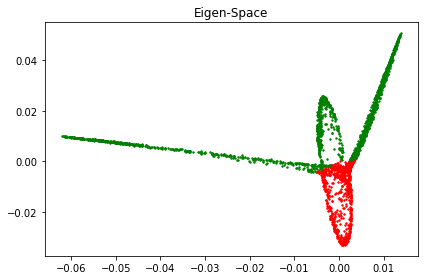

In [16]:
image_name = ['image1.png', 'image2.png']
mode = 'random'
cut = 'normalized'
K = 2
for name in image_name:
    print(f'kernel k-means for {name} start, initial center by method {mode}, pick {K} points')
    image = cv2.imread('data/'+ name, cv2.IMREAD_UNCHANGED)
    info_S, info_C = extract_info(image)
    Gram_matrix = kernel(gamma_S=0.001, gamma_C=0.01, S=info_S, C=info_C) 
    L = compute_Laplacian(W=Gram_matrix, cut=cut)
    eigen_val, eigen_vec = compute_eigen(L=L, mode=mode, cut=cut, image_name=name)
    U = compute_U(eigen_val, eigen_vec, K=K)
    T = compute_T(U)
    history = kernel_Kmeans(K=K, U=T, mode=mode, image_name=name)
    generate_gif(name)

    #print(history)
    drawEigenSpace(K=K, eigen=U, cluster=history[-1], cut=cut, imagename=name)